# Exercise 5 (due by Sunday 12/6)

*   **Do not forget to answer both Part A and Part B.**
*   **Please run on Google colab (colab.research.google.com).**

# Part A
In the first part of exercise 5, we will investigate the dynamics of a disordered protein using the string-of-beads model. In the second part, we will review the course material briefly using multiple-choice questions.
## Preparations
### I. Installing IMP
The Integrative Modeling Platform [IMP](https://integrativemodeling.org/) is a software package for integrative (data-driven) modeling of molecular structure and dynamics. It is written in C++ and Python, and has a Pythn interface. To allow Google Colab to use IMP, we shall first install the IMP package:

In [ ]:
!echo "deb https://integrativemodeling.org/latest/download $(lsb_release -cs)/" > /etc/apt/sources.list.d/salilab.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 22A3BF2B
!apt update
!apt install imp
import sys
sys.path.append('/usr/lib/python3.6/dist-packages')

Executing: /tmp/apt-key-gpghome.dQhkzJU6MD/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 22A3BF2B
gpg: key EE70051722A3BF2B: public key "Ben Webb <ben@salilab.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:5 https://integrativemodeling.org/latest/download bionic/ InRelease [1,781 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:10 http://ppa.launchpad.net/deadsnakes/ppa/ubu

Import some IMP packages:

In [ ]:
import IMP.atom
import IMP.algebra
import IMP.rmf
import IMP.core
import RMF
import IMP.container
import IMP.display
import IMP.npctransport

### II. Classes 
We prepared two classed, one for representing protein chains as strings-of-beads, and the other for generating such classes (a "factory" class)

#### ProteinChain class
We defined a class called `ProteinChain` for you. This class holds information about a single protein chain, represented as a string of beads. It's a simple class - some key methods include `beads()` - returning the bead of the string, and `restraint()` - returning the springs connecting the beads (you will see). 

We've kept it hidden (though you can feel free to look inside). Don't worry if you don't understand all of the code - just run this cell for now:

In [ ]:
#@title
from dataclasses import dataclass

@dataclass # https://docs.python.org/3/library/dataclasses.html
class ProteinChain:
  '''
  A string-of-beads representation of a protein chain
  from specified beads. The beads are connected by a restraint
  (think springs between consecutive beads)
  '''
  # the "parent" of all beads in the chain
  root_p : IMP.Particle 
   # the list of bead particles comprising the chain
  beads : list 
  # a spring restraint on consecutive beads
  restraint : IMP.Restraint 
  # The protein sequence that this chain represents
  sequence : str 

  def __post_init__(self): # this is called by automatically generated __init__
      # make sure root is the parent of all beads
      for bead in self.beads:
        assert IMP.atom.Hierarchy(bead).get_parent() == self.root_as_h

  @property
  def model(self) -> IMP.Model : 
    return self.root_p.get_model()
    
  @property # Hierarchy is a decorator 
  def root_as_h(self) -> IMP.atom.Hierarchy : 
    return IMP.atom.Hierarchy(self.root_p)

#### ProteinChainFactory class
We also included a class for generating `ProteinChain` objects for various protein sequences. Details will be explained below, just run for now:

In [ ]:
#@title
FAKE_MASS = 1.0

class ProteinChainFactory:
    '''
    A class for generating chains of beads
    '''
    def __init__(self,
                 model : IMP.Model, 
                 default_radius_A : float = 10.0 , # bead radius in angstroms (10^-10 m)
                 relative_rest_distance : float = 2.0, # distance between bead centers, relative to radius
                 k_kcal_per_mol_per_A2 : float = 1.0, # force coefficient for spring connecting consecutive beads in kcal/mol/A^2 (force is k*distance
                 nres_per_bead : int = 5):
        '''
        :param model 
        :param default_radius_A       Bead radius in angstroms
        :param relative_rest_distance Distance between bead centers, relative to radius
        :param k_kcal_per_mol_per_A2  Force coefficient for spring connecting consecutive beads 
                                      in kcal/mol/A^2 units
        :param nres_per_bead          Number of protein residues represented by a single bead
        '''
        self._model = model
        self._default_radius_A = default_radius_A
        self._rest_distance_A = relative_rest_distance * default_radius_A 
        self._k_kcal_per_mol_per_A2 = k_kcal_per_mol_per_A2
        self._nres_per_bead = nres_per_bead
    @property
    def model(self): return self._model
    @property
    def default_radius_A(self): return self._default_radius_A
    @property
    def rest_distance_A(self): return self._rest_distance_A
    @property
    def k_kcal_per_mol_per_A2(self): return self._k_kcal_per_mol_per_A2
    @property
    def nres_per_bead(self): return self._nres_per_bead
    
    def _create_bead(self, 
                     name : str):
        p= IMP.Particle(self.model, name)
        p_as_xyzr= IMP.core.XYZR.setup_particle(p) # A Decorator design pattern - adding functionality to an object at run time (~run-time inheritance)
        p_as_xyzr.set_coordinates_are_optimized(True)
        p_as_xyzr.set_radius(self.default_radius_A)
        IMP.atom.Mass.setup_particle(p, FAKE_MASS)   # required by Hierarchy
        IMP.atom.Diffusion.setup_particle(p)
        IMP.atom.Hierarchy.setup_particle(p) # allow inclusion in IMP hierarchies
        IMP.display.Colored.setup_particle(p,
                                           IMP.display.get_display_color(0))
        return p

    def _create_restraint(self,
                          beads #spring constant
                       ):
      hdps = IMP.core.HarmonicDistancePairScore(self.rest_distance_A, 
                                                self.k_kcal_per_mol_per_A2)
      cpc = IMP.container.ConsecutivePairContainer(self.model, beads) # convention - use abbreviation for multiword class names
      pr = IMP.container.PairsRestraint(hdps, cpc)
      return pr, hdps


    def create(self, 
               sequence : str, # protein sequence 
               name: str): # a name of your choice for the protein chain
      p= IMP.Particle(self.model, name)
      p_as_h = IMP.atom.Hierarchy.setup_particle(p) # allow inclusion in IMP hierarchies
      # add beads:
      n = len(sequence)
      nbeads = max(1, round(n / self.nres_per_bead))
      beads = []
      for i in range(nbeads):
        bead = self._create_bead(f"{name}_{i}") 
        p_as_h.add_child(bead) 
        beads.append(bead)
      # restrain beads on a "string":
      restraint, harmonic_distance_pair_score = self._create_restraint(beads)
      return ProteinChain(root_p = p, 
                          beads = beads, 
                          restraint = restraint,
                          sequence = sequence)

## Building a dynamic model - parts, interactions, dynamics
OK, let's begin by building our first dynamic model! As we learned in class, a dynamic model stands on three pillars: parts, interactions, and dynamics. 

But first we need to construct an [IMP `model`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1Model.html):

In [ ]:
m = IMP.Model()

### I. Add parts 
#### Generate strings of beads
In IMP, model parts are called [Particles](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1Particle.html). The beads in our `ProteinChain` object are such particles - in this case, they represent physical objects with Cartesian coordinates. 

To generate two string of beads, we use the `ProteinChainFactory` class `create()` method:  

In [ ]:
protein_chain_factory = ProteinChainFactory \
  (model = m, # the model in which the beads reside
   default_radius_A = 10.0, # radius of a bead
   k_kcal_per_mol_per_A2 = 5.0, # the force coefficient for the spring holding consecutive beads together (large number = stiff spring)
   relative_rest_distance = 3.0, # the resting distance between bead centers, relative to the radius of single bead
   nres_per_bead = 20) # number of residues per bead in the string-of-beads
seq = "MSDQSQEPTMEEILASIRRIISEDDAPAEPAAEAAPPPPPEPEPEPVSFDDEVLELTDPI" \
      "APEPELPPLETVGDIDVYSPPEPESEPAYTPPPAAPVFDRDEVAEQLVGVSAASAAASAF" \
      "GSLSSALLMPKDGRTLEDVVRELLRPLLKEWLDQNLPRIVETKVEEEVQRISRGRGA"
label = "popZ"
nchains = 2
chains = []
for i in range(nchains):
  chain = protein_chain_factory.create(seq, f"{label}_{i}")
  chains.append(chain)

### Keep chains in a hierarchical data structure

Next, we create a hierarchical data struture, in which the two chain descend from a common root particle called `p_root`. Note that ProteinChainFactory made sure that the beads of each chain also descend from a common root `protein_chain.root_as_h`.




In [ ]:
p_root= IMP.Particle(m, "root")
h_root = IMP.atom.Hierarchy.setup_particle(p_root) # decorator
for chain in chains:
  h_root.add_child(chain.root_as_h)

**Explanation**: IMP Particles don't have to represent actual physical particles. To allow *particle* `p_root` to have children, we [decorate](https://https://en.wikipedia.org/wiki/Decorator_pattern) it using the [`IMP.atom.Hierarchy` class](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1atom_1_1Hierarchy.html). The [decorator design pattern](https://https://en.wikipedia.org/wiki/Decorator_pattern) adds new functions to existing classes at runtime instead of during compile time. Think about `h_root` as particle `p_root` cast as class Hierarchy.

### II. Add interactions
Interactions in IMP are created using the concept of a "restraint" acting on a group of particles (a single particle, a pair of particles, etc.). All restraints derive from the class [`Restraint`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1Restraint.html). 
 
We first define an [`ExcludedVolumeRestraint`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1core_1_1ExcludedVolumeRestraint.html) object - telling IMP that different beads should not overlap with each other, at least not too much:

In [ ]:
def get_all_beads(chains):
  beads_set = set().union(*[chain.beads for chain in chains])
  return list(beads_set)

# Add excluded volume restraints among all (close pairs of) particles:
evr = IMP.core.ExcludedVolumeRestraint(get_all_beads(chains), # particles to be restraints
                                      1.0, # force constant
                                      10.0, # slack parameter affecting speed only
                                      "Excluded-Volume" # a string identifier
                                       ) 

The springs between the beads of each protein chain were already defined by ProteinChainFactory, so now we create `rsf`, a scoring function (a.k.a. energy function) made of our restraints.

In [ ]:
restraints = [chain.restraint for chain in chains] + [evr]
rsf = IMP.core.RestraintsScoringFunction(restraints, 
                                         "Scoring function") # Energy function

### III. Add dynamics
Finally, we create a [`BrownianDynamics`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1atom_1_1BrownianDynamics.html) object, which enables us to simulate our interacting parts:

In [ ]:
# BD
bd = IMP.atom.BrownianDynamics(m)
bd.set_scoring_function(rsf) # tell BD about our scoring (energy) function
bd_step_size_fs = 1000.0 # simulation time step in femotoseconds (10^-15 sec)
bd.set_maximum_time_step(bd_step_size_fs) 
T = 300 # temperature in Kalvin
bd.set_temperature(T)

#### Making a movie (trajectory) file
We conclude by telling our simulation to output a trajectory (movie) file every 10000 frames. The movie is saved using the [Rich Molecular File format](https://integrativemodeling.org/rmf/format.html), which can be viewed using e.g. the [Chimera software](https://www.cgl.ucsf.edu/chimera/download.html) or [ChimeraX](https://cxtoolshed.rbvi.ucsf.edu/apps/chimeraxrmf).
 
**Note:** if you get a "UsageError: "Opening a file that is still being written is asking for trouble." error for any reson, just change the filename variable

In [ ]:
rmf_filename = "my_trajectory_I.rmf"
rmf = RMF.create_rmf_file(rmf_filename)
rmf.set_description("Brownian dynamics trajectory with {}fs timestep.\n"\
                    .format(bd_step_size_fs))
IMP.rmf.add_hierarchy(rmf, h_root) # Telling the movie that it should save all descendents of h_root
IMP.rmf.add_restraints(rmf, restraints) # the restraints are also saved and can be viewed in Chimera
sos = IMP.rmf.SaveOptimizerState(m, rmf) # an optimizer state is invoked every n frames of simulation by the BD simulation
sos.set_simulator(bd)
frames_interval = 2500
sos.set_period(frames_interval) 
bd.add_optimizer_state(sos)
sos.update_always("initial conformation") # save the initial conformation to the RMF file


## Simulating dynamics
Without further ado, let's simulate our system using `bd.optimize(n)` where `n` is the number of time steps to simulate. 

We shall keep a few statistics every `n_inner_cycle` frames - the simulation time, the energy of the system (our scoring function), and the distance between the first and last bead of each chain.


In [ ]:
T_ns = [] # time in nanoseconds
E = [] # energy
D = [ [] for chain in chains ]
n_outer = 50000 # outer loop number of iterations
n_inner = 250 # optimization per iteration
for i in range(n_outer):
  time_fs = bd.get_current_time()
  time_ns = time_fs * 1e-6 # a nanosecond is a million femtoseconds
  if (i % (n_outer//10) == 0):
    print(f"Simulated for {time_ns:.1f} nanoseconds so far")
  bd.optimize(n_inner)
  T_ns.append(time_ns) # keep time
  E.append(bd.get_last_score()) # keep energy
  for i, chain in enumerate(chains): # keep distances for each chain
    distance = IMP.core.get_distance(IMP.core.XYZ(chain.beads[0]), 
                                     IMP.core.XYZ(chain.beads[-1]))
    D[i].append(distance)
print(f"FINISHED. Simulated for {time_ns:.1f} nanoseconds in total.")
rmf.flush() # make sure RMF file is properly saved

Simulated for 0.0 nanoseconds so far
Simulated for 1250.0 nanoseconds so far
Simulated for 2500.0 nanoseconds so far
Simulated for 3750.0 nanoseconds so far
Simulated for 5000.0 nanoseconds so far
Simulated for 6250.0 nanoseconds so far
Simulated for 7500.0 nanoseconds so far
Simulated for 8750.0 nanoseconds so far
Simulated for 10000.0 nanoseconds so far
Simulated for 11250.0 nanoseconds so far
FINISHED. Simulated for 12499.8 nanoseconds in total.


Let's convert to numpy array - it will be easier to manipulate that way:

In [ ]:
import numpy as np
T_ns = np.array(T_ns) # this will be convenient later
E = np.array(E) # likewise
D = np.array(D)

**Explanations:**

To compute the energy of the system we use the `bd.get_last_score()` method.

To compute the distance between the centers of two bead particles, we use the [`IMP.core.get_distance()`](https://integrativemodeling.org/2.15.0/doc/ref/namespaceIMP_1_1core.html#af2049fdca8aae38e86549cfdeff1d1fc) function. This functions acts on [`IMP.core.XYZ`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1core_1_1XYZ.html) objects. 

*Advanced note:* bead particles can be converted (cast) to `IMP.core.XYZ` objects because they were decorated as such by our `ProteinChainFactory` class.

## Visualizing simulation results
Let's see what happened. Since we kept statistics, we can now plot the energy and the distance between beads as a function of time. Optionally, you can frist inspect the resulting simulation as a movie in Chimera.

####**Bonus Question A0 (+2):**
Download and install the [Chimera software](https://www.cgl.ucsf.edu/chimera/download.html), download the output RMF file (press on the files icon in the left tab and look for the output file, you can download it from there). Open it in Chimera and play the movie. Explore the hierarchy of particles on the right panel. You may select differtent chains or beads, color them in different colors, etc. 

**Please share your observations in a few sentences (in Hebrew if you like).**

*Note:* Alternatively, you can use ChimeraX. It requires installation of the RMF plugin (Tools - more tools - RMF - Install), and a few simple command lines - if you're interested, you can try the following sequence of commands and take it from there:
1.   `open "<PATH>/<filename>.rmf"`
2.   `rmf readtraj #1.1` (you may need to replace 1.1 with the appropraiate ID on the Models panel)
3.   `coordset slider #1.1` (this will open a slider for playing the movie, you may need to replace 1.1 with the appropriate ID as before)
  

####**Bonus Answer A0:**
When exploring the hierarchy on the right panel we can see that there are two chains that contains 8 beads (which make sense since there are 177 amino acids in the sequence and each bead contains 20 residues), and are the children of a single root. 
We can see that there is movement of the beads, as expected.
We colored each chain in a different color as seen in the following picture:
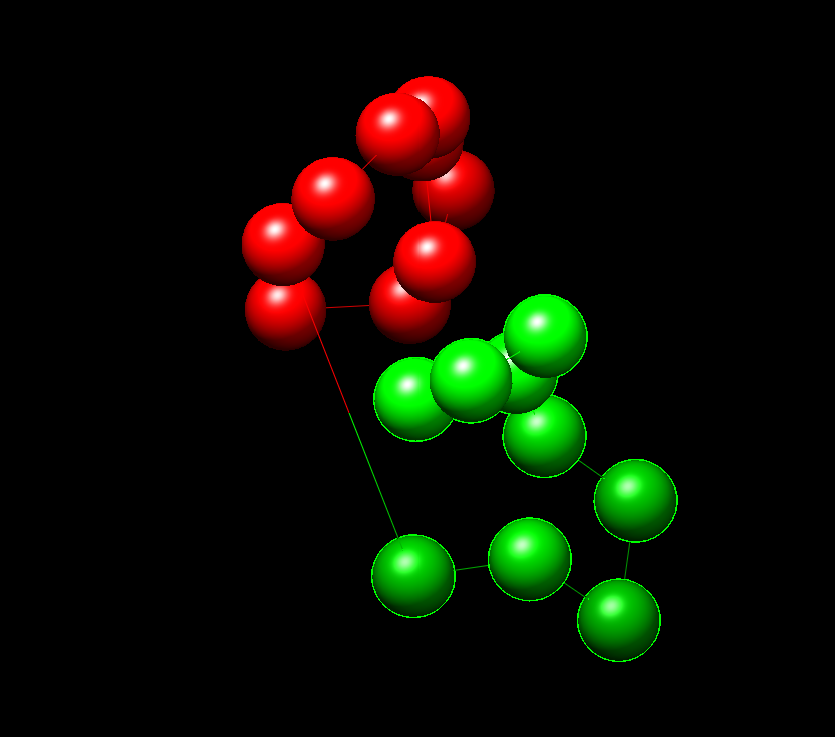

####**Question A1:**
Please add appropriate code, such that the simulation energy is plotted as a function of time using [`matplotlib.pyplot.plot()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) function. 

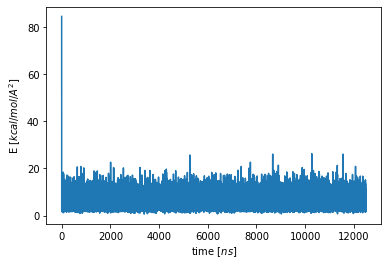

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(T_ns, E)
plt.xlabel(r'time [$ns$]')
plt.ylabel(r'E [$kcal/mol/A^2$]')
plt.show()


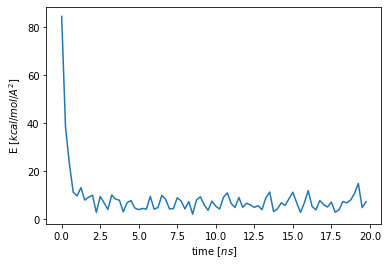

In [ ]:
import numpy as np # TODO - Erase This!!!!!!!!!!!!
T_ns_threshold = 20 # CHANGE THIS LINE ONLY
no_end = (T_ns < T_ns_threshold)
# print(no_end)
plt.plot(T_ns[no_end], E[no_end], '-') 
plt.xlabel(r'time [$ns$]')
plt.ylabel(r'E [$kcal/mol/A^2$]')
plt.show()

####**Question A2:**
**You may answer in hebrew (here and in all questions below).** 

What happened to the simulation energy at the early stages of the simulations? Why?

####**Answer A2:**
 In the following plot we ploted the energy at the early stages of the simulation:
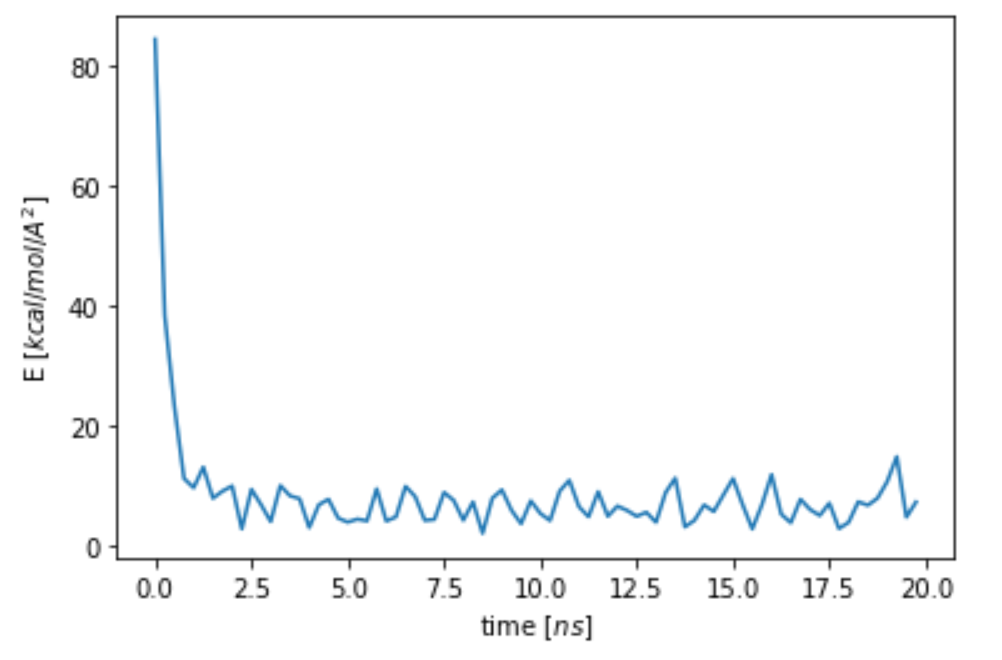
We can see that at the start of the simulation the energy is high, and in the early stages of the simulation the energy decreases. We can explain this by the fact that at the start of the simulation the chains are in a arbitary conformation, with high energy and at the early stages of the simulation, the chains are organized in a native low energy conformation. 

###**Question A3:**
 
Let's plot the simulation energy only after the initial equilibration time. Change the value of `T_ns_threshold` until the plot only shows a simulation energy that does not trend down

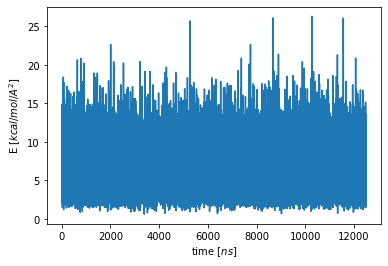

In [ ]:
#A3
import numpy as np
T_ns_threshold = 3 # CHANGE THIS LINE ONLY
no_start = (T_ns > T_ns_threshold)
plt.plot(T_ns[no_start], E[no_start], '-') 
plt.xlabel(r'time [$ns$]')
plt.ylabel(r'E [$kcal/mol/A^2$]')
plt.show()

####**Question A4:** 
**You may answer in Hebrew here and in all questions below.** 

Print the mean and standard deviation of the simulation energy by running the next cell of code. What would happen to the standard deviation of the energy if we decreased the simulation temperature? Would it go up or down? Please explain why so based on the equation of Brownian dynamics that we learned in class. 

Optionally, feel free to create a copy of this document and test what happens when you actually change the simulation temperature by changing the code above `bd.set_temperature(T)`.

####**Answer A4:**
When decreaing the simulation tempreture, the standard deviation of the energy will decrease. Indeed, when we decreased the simulation tempreture we got a lower standard deviation (1.27 when T=150, and 2.53 when T=300).
In class we saw the following equation:

  $X_{n+1}=X_n + \frac{\Delta{t}}{k_B T}{cT} \cdot {f(X_n)} + \sqrt{2d \cdot cT \cdot \Delta{t}} \cdot R$ 

In the next question we see that this eqution is equal to the following equation:
   $X_{n+1}=X_n + \frac{c\cdot\Delta{t}}{k_B} \cdot {f(X_n)} + \sqrt{2d \cdot cT \cdot \Delta{t}} \cdot R$ 

Thus, we can see that as T decreases, the value of  $X_{n+1}$ is closer to the value of $X_{n}$, i.e the difference between the energy of two consecutive configurations decreases, and therefore the standard deviation of the enregy decreases.

In [ ]:
print(f"The mean energy is {np.mean(E[no_start]):.2f}")
print(f"The std-deviation of the energy is {np.std(E[no_start]):.2f}")

The mean energy is 6.05
The std-deviation of the energy is 2.53


###**Question A5:**
Inspect the equation of BD as in the previous question. 

*Fact:* The diffusion coefficent *D* in the equation increases proportionally to the temperature *T*. In other words, you may substitute *D* for *cT*. 

If *T* tends (שואף) to zero, what would be the form of the BD equation? Is there any term that disappears?

*Hint:* you don't have to, but if you change the `bd.set_temperature()` line above, you can check it first hand. Don't forget to change it back again (or work on a copy of this notebook).

###**Answer A5:**
When substituting D with cT we get the following equation:

  $X_{n+1}=X_n + \frac{\Delta{t}}{k_B T}{cT} \cdot {f(X_n)} + \sqrt{2d \cdot cT \cdot \Delta{t}} \cdot R$ 

  which equals to:
    $X_{n+1}=X_n + \frac{c\cdot\Delta{t}}{k_B} \cdot {f(X_n)} + \sqrt{2d \cdot cT \cdot \Delta{t}} \cdot R$ 

If T tends to zero, we get that the term:  $ \sqrt{2d \cdot cT \cdot \Delta{t}} \cdot R$ dissapers, so the form of the BD equation is:
  $X_{n+1}=X_n + \frac{c\cdot\Delta{t}}{k_B} \cdot {f(X_n)} $


###**Question A6:**
When *T* tends to zero, what algorithm that we learned earlier in the course do we get? 

###**Answer A6:**
When T tends to zero, this is the Gradient Descent algorithm. 

###**Question A7:**
The following code plots the end-to-end distance of the protein chains. The chains movement is somewhat remeniscent of changes in the stock market. How come? What universal phenomenon that we learned in class may explain this qualitative similarity?
 
###**Answer A7:**
Using the central limit theorem we get that the probabilities of random walk approaches a normal distribution as n increases. All universal problems that are affected by random changes can be modeled as a random walk, which with time will convege to normal distribution. 

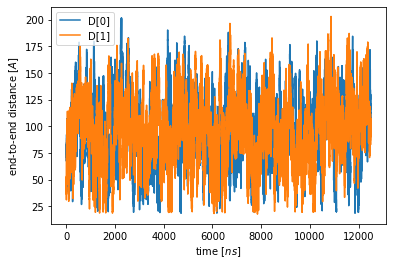

In [ ]:
from matplotlib import cm
colors =  cm.get_cmap("tab10")
for i,Di in enumerate(D):
  plt.plot(T_ns[no_start], Di[no_start],
           color=colors(i % 10), label=f'D[{i}]') 
plt.xlabel(r'time [$ns$]')
plt.ylabel(r'end-to-end distance [$A$]')
plt.legend()
plt.show()

###**Bonus question A8 (+2):**
(Bonus +2 points) Let us plot the distribution of the system's energy over time (in units of kcal/mol/A^2 - nevermind) by running the following cell. We know that Brownian dynamics simulations converge to the Boltzmann distribution, that is, their probability to be in a certain configuration decreases exponentially as the energy of that configuration increases. 

How come the following histogram does not decay exponentially with increasing energy? 

*Hint*: Is there an equal number of configurations at each energy level?

###**Bonus answer A8 (+2):**
Since there is an unequal number of configurations at each energy level, the count in the histogram doesn't reflect  the probability to be in a certain configuration, but the probability to be at a certain energy level. If we will normalize the count in each energy level by the number of configurations in that energy level, we might get a histogram that decays exponentially with increasing energy.

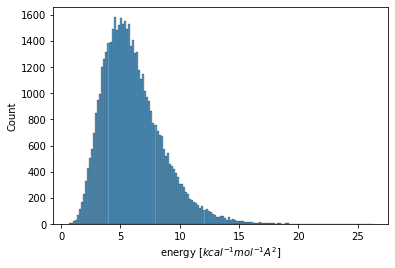

In [ ]:
import seaborn as sns
ax = sns.histplot(E[no_start])
ax.set_xlabel(r'energy [$kcal^{-1}mol^{-1}A^2$]')
plt.show()


###**Question A9:**

Let's plot the distribution of end-to-end distances over time in the two chains combined. 

  a. According to what we learned in class, why is it (approximately) a Gaussian?

  b. Why is it not precisely a Gaussian? Try to think of two reasons.
  
  *Hints for b:* Are the springs the only interactions between beads or did we add another type of interaction except the springs? Also, is there a lower bound to the end-to-end distances that's diffferent than that of a Normal distribution?

###**Answer A9:**
a. As leraned in class, a random walk convegres to Gaussian distribution, and we can think of protein movement as a process of a random walk. 

b.
* In reality, there are water molecules that interact with the beads that affect the end-to-end distances. This may lead to an imprecise Gaussian distribution. 
* Since we defined an ExcludedVolumeRestraint object - telling IMP that different beads should not overlap with each other, at least not too much, we can infer that there is a lower bound to the end-to-end distances. This lower bound may be different from the lower bound of a normal distribution and consequently leads to an  imprecise Gaussian distribution.


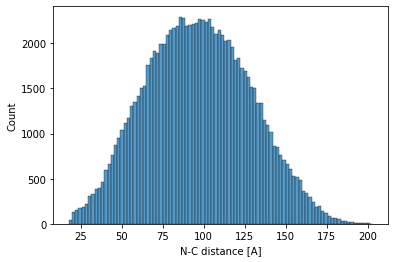

End-to-end distance stats:
The bottom 2.5% are less than 38.1 A
The bottom 10.0% are less than 55.2 A
The median 50.0% is 96.2 A
The top 90.0% are more than 138.7 A
The top 97.5% are more than 158.9 A


In [ ]:
def plot_hist_end_to_end(D):
  D_c = np.concatenate(D[0:])
  ax = sns.histplot(D_c)
  ax.set_xlabel(r'N''-C'' distance [A]')
  plt.show()
  print(f"End-to-end distance stats:")
  print(f"The bottom 2.5% are less than {np.percentile(D_c, 2.5):.1f} A")
  print(f"The bottom 10.0% are less than {np.percentile(D_c, 10.0):.1f} A")
  print(f"The median 50.0% is {np.percentile(D_c, 50.0):.1f} A")
  print(f"The top 90.0% are more than {np.percentile(D_c, 90.0):.1f} A")
  print(f"The top 97.5% are more than {np.percentile(D_c, 97.5):.1f} A")

plot_hist_end_to_end(D)

# Adding an attractive potential

Let's add some attractions between pairs of beads that lie close to each other in space and see how it affects the simulation. We use a truncated harmonic energy potential - that is, the energy $E(d)$ increases to the square of the distance $d$ between the two spheres relative to center point $c$ with a force constant $k$, such that $E(d)=0.5 \cdot k \cdot (d-c)^{2}$. The potential is truncated from above, such that beyond a certain threshold, the energy no longer increases. 


See https://integrativemodeling.org/nightly/doc/ref/classIMP_1_1core_1_1TruncatedHarmonic.html

In [ ]:
def get_attraction_pairs_restraint \
( beads,
  center_A = 0, # = touch each other
  k_kcal_per_mol_A2 = 0.01, 
  threshold_A = 10, 
  close_pairs_slack_A = 3.0 ):
  ''' 
  @param center_A 
         The distance between sphere surfaces with minimal energy in angstroms.
  @param k_kcal_per_mol_A2 
         A measure of how strong the attraction is. Formally, it specifies the
         spring constant for attraction between spheres where
         kcal/mol are molecular energy units (kilocalories per mole), and A2
         stands for angstrom-squared.
  @param threshold_A 
         Maximal distance for harmonic potential
  @param close_pairs_slack_A 
         A parameter for an algorithm for efficiently finding close pairs of 
         spheres (changing this could affect simulation running time)
  @return an attractive restrain over a list of bead particles 
  '''
  truncated_harmonic = IMP.core.TruncatedHarmonicUpperBound \
    ( center_A, 
      k_kcal_per_mol_A2, 
      threshold_A)
  pair_score = IMP.core.SphereDistancePairScore(truncated_harmonic) # applies truncated harmonic on the distance between pairs of spheres
  close_pairs = IMP.container.ClosePairContainer(beads, 
                                                 threshold_A, 
                                                 close_pairs_slack_A)
  pairs_restraint = IMP.container.PairsRestraint(pair_score, close_pairs) # apply the pair score to all pairs of close-by spheres
  return pairs_restraint



Now let's create a simulation with the new dynamics and run it:

In [ ]:
# Create chains:
seq = "MSDQSQEPTMEEILASIRRIISEDDAPAEPAAEAAPPPPPEPEPEPVSFDDEVLELTDPI" \
      "APEPELPPLETVGDIDVYSPPEPESEPAYTPPPAAPVFDRDEVAEQLVGVSAASAAASAF" \
      "GSLSSALLMPKDGRTLEDVVRELLRPLLKEWLDQNLPRIVETKVEEEVQRISRGRGA"
label = "popZ"
nchains = 2
chains = []
for i in range(nchains):
  chain = protein_chain_factory.create(seq, f"{label}_{i}")
  chains.append(chain)

# Hierarchy of particles:
p_root= IMP.Particle(m, "root")
h_root = IMP.atom.Hierarchy.setup_particle(p_root) # decorator
for chain in chains:
  h_root.add_child(chain.root_as_h)

# Add excluded volume restraints among all (close pairs of) particles:
evr = IMP.core.ExcludedVolumeRestraint(get_all_beads(chains), # particles to be restraints
                                      1.0, # force constant
                                      10.0, # slack parameter affecting speed only
                                      "Excluded-Volume" # a string identifier
                                       ) 

# Add an attractive bead-bead restraint to the previous restraints 
attraction_restraint = get_attraction_pairs_restraint(get_all_beads(chains))
restraints = [chain.restraint for chain in chains] + [evr, attraction_restraint]
rsf = IMP.core.RestraintsScoringFunction(restraints, 
                                         "Scoring function") # Energy function

# Set a second Brownian dynamics simulation with the new restraint
bd = IMP.atom.BrownianDynamics(m)
bd.set_scoring_function(rsf) # tell BD about our scoring (energy) function
bd_step_size_fs = 1000.0 # simulation time step in femotoseconds (10^-15 sec)
bd.set_maximum_time_step(bd_step_size_fs) 
T = 300 # temperature in Kalvin
bd.set_temperature(T)

# Add an RMF movie
rmf_filename = "my_trajectory_II.rmf"
rmf = RMF.create_rmf_file(rmf_filename)
rmf.set_description("Brownian dynamics trajectory with {}fs timesteps for attractive potential.\n"\
                    .format(bd_step_size_fs))
IMP.rmf.add_hierarchy(rmf, h_root) # Telling the movie that it should save all descendents of h_root
IMP.rmf.add_restraints(rmf, restraints) # the restraints are also saved and can be viewed in Chimera
sos = IMP.rmf.SaveOptimizerState(m, rmf) # an optimizer state is invoked every n frames of simulation by the BD simulation
sos.set_simulator(bd)
frames_interval = 2500
sos.set_period(frames_interval) 
bd.add_optimizer_state(sos)
sos.update_always("initial conformation") # save the initial conformation to the RMF file
bd.optimize(1)
print(f"attractive score start = {attraction_restraint.get_score():.1f}")
bd.optimize(100)
print(f"attractive score after 100 frames = {attraction_restraint.get_score():.1f}")
# Simulate dynamics:
T_ns = [] # time in nanoseconds
E = [] # energy
D = [ [] for chain in chains ]
n_outer = 50000 # outer loop number of iterations
n_inner = 250 # optimization per iteration
for i in range(n_outer):
  time_fs = bd.get_current_time()
  time_ns = time_fs * 1e-6 # a nanosecond is a million femtoseconds
  if (i % (n_outer//10) == 0):
    print(f"Simulated for {time_ns:.1f} nanoseconds so far")
    print(f"attractive score = {attraction_restraint.get_score():.1f}")
  bd.optimize(n_inner)
  T_ns.append(time_ns) # keep time
  E.append(bd.get_last_score()) # keep energy
  for i, chain in enumerate(chains): # keep distances for each chain
    distance = IMP.core.get_distance(IMP.core.XYZ(chain.beads[0]), 
                                     IMP.core.XYZ(chain.beads[-1]))
    D[i].append(distance)
print(f"FINISHED. Simulated for {time_ns:.1f} nanoseconds in total.")
rmf.flush() # make sure RMF file is properly saved

attractive score start = 0.0
attractive score after 100 frames = 32.6
Simulated for 0.1 nanoseconds so far
attractive score = 32.6
Simulated for 1250.1 nanoseconds so far
attractive score = 15.7
Simulated for 2500.1 nanoseconds so far
attractive score = 17.5
Simulated for 3750.1 nanoseconds so far
attractive score = 17.3
Simulated for 5000.1 nanoseconds so far
attractive score = 20.7
Simulated for 6250.1 nanoseconds so far
attractive score = 20.9
Simulated for 7500.1 nanoseconds so far
attractive score = 21.2
Simulated for 8750.1 nanoseconds so far
attractive score = 15.9
Simulated for 10000.1 nanoseconds so far
attractive score = 19.4
Simulated for 11250.1 nanoseconds so far
attractive score = 18.0
FINISHED. Simulated for 12499.9 nanoseconds in total.


And plot the distribution of N-C distances

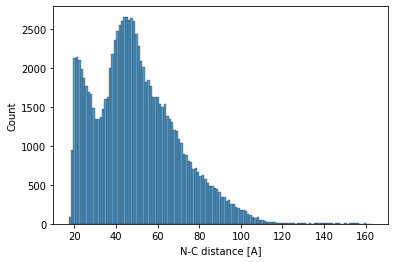

End-to-end distance stats:
The bottom 2.5% are less than 20.3 A
The bottom 10.0% are less than 24.4 A
The median 50.0% is 47.5 A
The top 90.0% are more than 77.3 A
The top 97.5% are more than 94.5 A


In [ ]:
plot_hist_end_to_end(D)

###**Question A10:**

Compare to A9 - what has changed in the distribution of end-to-end distances? Why so? (explain in 1-2 sentences). 

You will get a +2 points bonus if you also post a snapshot from the simulation.

###**Answer A10:**
We can see that there are much more configurations with low N-C distance. The distribution shifted to the left and it doesn't look like a Gaussian anymore. Because we added attractions between close beads, we will expect that the end-to-end distance of each chain will decrease, and that is indeed what we see in the distribution. 

We can see in the simulation that the end-to-end distance decreased, and the chains are closer to each other:
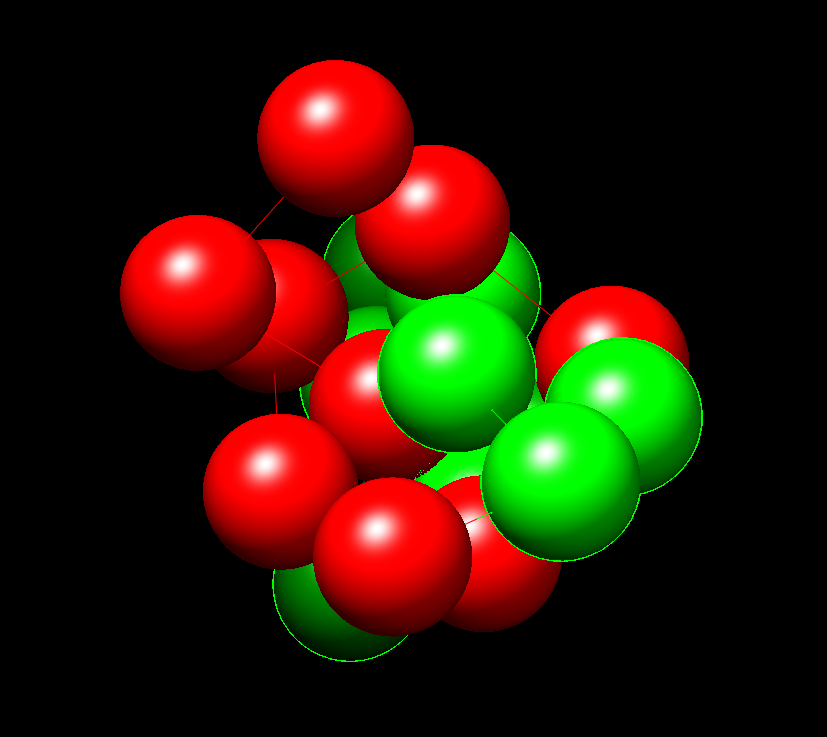
###**Question A11:**

From a theoretical point of view, what would you expect should happen to the distribution of end-to-end distances if you increase the value of the *k_kcal_per_mol_A2* argument of *get_attraction_pairs_restraint()*? Explain in 1-2 sentences.

###**Answer A11:**

We would expect that the distribution of the end-to-end distances will shift more to the left since as the *k_kcal_per_mol_A2* argument increases, the energy E(d) increases (because this argument represents the spring constant), so the attraction between close beads will increase.

###**Bonus questions A12 (+5 in total):**

a. The distribution ends abruptly at a lower bound at around 20A. The same lower bound is observed in A9. Why so? (1-2 sentences). Watching the trajectories in Chimera might help inspire an answer.

b. What about the upper bound? (1-2 sentences)

c. The distribution is bimodal (double-peaked). We are not entirely sure why (but we have some guesses). Feel free to come up with your own guesses. Any guess is as good as ours, but better if you provide (brief) scientific support.

###**Bonus Answers A12:**

a. Since we defined an ExcludedVolumeRestraint object - telling IMP that different beads should not overlap with each other, at least not too much, we can infer that there is a lower bound to the end-to-end distance. This lower bound will appear in both cases. 


b. There are different upper bounds in both cases, as the distrbution shifted to the left. 

####**Enrichment:**
Let's inspect the code of classes `ProteinChain` and `ProteinChainFactory` way above by pressing "show code". This brief explanation is provided for context, you can move on with the exercise if you like.

The method `create_bead()` creates a single bead, and decorates it with  [`IMP.core.XYZR`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1core_1_1XYZR.html), [`IMP.atom.Mass`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1atom_1_1Mass.html), [`IMP.atom.Diffusion`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1atom_1_1Diffusion.html), and [`IMP.display.Colored`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1display_1_1Colored.html).
    
    def _create_bead(self, 
                     name : str):
        p= IMP.Particle(self.model, name)
        p_as_xyzr= IMP.core.XYZR.setup_particle(p) # A Decorator design pattern - adding functionality to an object at run time (~run-time inheritance)
        p_as_xyzr.set_coordinates_are_optimized(True)
        p_as_xyzr.set_radius(self.default_radius_A)
        IMP.atom.Mass.setup_particle(p, FAKE_MASS)   # required by Hierarchy
        IMP.atom.Diffusion.setup_particle(p)
        IMP.atom.Hierarchy.setup_particle(p) # allow inclusion in IMP hierarchies
        IMP.display.Colored.setup_particle(p,
                                           IMP.display.get_display_color(0))
        return p


The method `_create_restraint` adds a spring to the simulation between each pair of consecutive beads. It first creates a function that increases quadratically from a certain rest distance - using the class [`IMP.core.HarmonicDistancePairScore`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1core_1_1HarmonicDistancePairScore.html). The [`IMP.container.PairsRestraint`](https://integrativemodeling.org/2.15.0/doc/ref/classIMP_1_1container_1_1PairsRestraint.html) object `pr` is a restraints that applies this function (`hdps`) over each pair of consecutive beads (`cpc`).

    def _create_restraint(self,
                          beads #spring constant
                       ):
      hdps = IMP.core.HarmonicDistancePairScore(self.rest_distance_A, 
                                                self.k_kcal_per_mol_per_A2)
      cpc = IMP.container.ConsecutivePairContainer(self.model, beads) # convention - use abbreviation for multiword class names
      pr = IMP.container.PairsRestraint(hdps, cpc)
      return pr, hdps




# Probabilistic modeling (enrichment)

There are no questions to answer in this section, so you can skip right on to **Part II** if you like. If you're still here, you will find some simple code for fitting the probability distribution of the energy and chain end-to-end distance distributions above, using the probabilistic modeling package [PyMC3](https://docs.pymc.io/).

First install some required packages:

In [ ]:
!pip install theano-pymc
!pip install pymc3==3.11.1

Define a probabilistic model made of a bunch of random variables ("RVs"):

In [ ]:
import pymc3 as pm
import numpy as np
pm_model = pm.Model()
with pm_model:
  rv_E_mu = pm.Normal('E_mu', mu = 20, sigma = 20)
  rv_E_sigma = pm.Normal('E_sigma', mu = 20, sigma = 20)
  rv_E = pm.Normal('E', mu = rv_E_mu, sigma = rv_E_sigma, 
                   observed = E)
  rv_D_mu = pm.Normal('D_mu', mu = 100, sigma = 50)
  rv_D_sigma = pm.Normal('D_sigma', mu = 50, sigma = 25)
  rv_D = pm.Normal('D', mu = rv_D_mu, sigma = rv_D_sigma, 
                   observed = np.concatenate(D))
gv = pm.model_to_graphviz(pm_model)        

Plot probabilistic relations:

In [ ]:
gv

Run Hamiltonian Markov-Chain Monte-Carlo to sample the mean (mu) and std-dev (sigma) for the various distributions:

In [ ]:
with pm_model:
    trace = pm.sample(500, chains=2);

In [ ]:
#!pip install arviz
import arviz as az
with pm_model:
    az.plot_trace(trace)

In [ ]:
az.summary(trace)

# PART B - Course Overview:

###**Questions B1-B7:**

#### Please provide short (1-2 sentence) answers as much as possible.

1. List two different ways to represent a protein structure discussed in the course. Calculate the number of degrees of freedom in each of them.

* XYZ coordinates - 6 degrees of freedom
* **ADD SOMETHING**
 

 
2. Explain briefly, in your own words, the steps of MCMC algorithm learned in class for sampling protein conformations using the Metropolis-Hastings criterion.
 
for each iteration:
  1. Choose a new conformation, drawn from a proposal distribution
  2. accept or reject the new conformation with probability P for acceptance and probability 1-p for rejection
If we accept a new conformation with probability of:

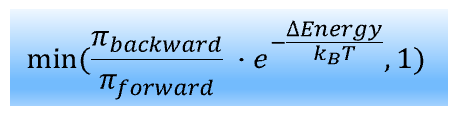

the MCMC algorithm converges to the Bolotzman distribution.

 
3. For each of the following neural networks layers, explain what it does and what we use it for?

    a. Convolutional layer - This layer creates a convolution kernel that is convolved with the layer input over a single spatial dimension to produce a tensor of outputs.

    b. Dropout layer - This layer randomly sets input units to 0 with a frequency of *rate* (=an argument of the layer) at each step during training time, which helps prevent overfitting. 

    c. Activation layer (Relu, Sigmoid…) - This layer performs non linear function on the input. Using this layer we can "help" the network learn complex patterns in the data.
 
4. Write down the input and the output of the following methods of structural bioinformatics, as described in the course (1-2 short sentences each):

    a. Proteins structural alignment
    * Input - structures of two proteins
    * Output - alignment between the two given proteins structures , and the RMSD of the alignment.

  b. ab initio folding
  * Input - sequence of a protein and an energy function. 
  * Output - 3D structure of the given protein, that minimizes the energy function. 

  c. Comparative modeling
  * Input - 
      * template structure
      * sequence alignment between target protein to template protein
  * Output - 3D structure of the target protein 

  d. K-medoids clustering
  * Input - 
      * set of data points
      * K - number of clusters
  * Output - the data points separated into K clusters
    
  e. Protein-protein docking
  * Input - two molecules in their native conformation
  *Output - 3D structure of the correct association between the given molecules

  f. Molecular dynamics
  * Input -
     * parts 
     * interactions between the parts
     * dynamics
  * Output - simulation of the motions of the atoms according to the forces between them
    
  g. Motion planning
  * Input - source, destination, object
  * Output - a sequence of valid configurations that moves the object from the source to destination
    
  h. Protein folding using deep learning (AlphaFold2 for example)
  * Input - sequence of proteins (as one hot encoding)
  * Output - 3D structure of the target protein 

5. Docking:

    a. List three docking algorithms, for each of them explain the main underlying concept (2-3 sentences).
    *  Dock -geometry based method that finds the interaction between protein and ligand. This method finds the complemet to the binding site and docks the lignad by alignmnet to the complemet found. 
    * FFT - this method finds the interaction between two protein using exhaustive search.it projects the proteins onto 3D grid, then for each rotaton of ligand, it evaluated all translations of ligand grid over receptor grid.  
    * PatchDock - geometry based method that finds the interaction between two proteins. 

  b. In many docking algorithms we are making some simplifying assumptions. Mention one such assumption and explain why we are making it. 

  c. Think of a case when this assumption doesn’t hold.

6. Protein folding (coevolution):
We learned that many protein folding algorithms are using multiple sequence alignment (MSA) as their input (instead of just a single sequence). How can the MSA help us to infer the protein structure? What additional information does it give us?

  We can find sequences that are similar to the target sequence and align them using MSA. Using this alignment, we can find positions in the sequence that are correlated with each other, so we can find a contact map and infer the structure of the target sequence using the contact map and the spatial constraints it gives. 

7.  When we learned about Brownian dynamics, we learned that the equation for updating the (high-dimensional) configuration $X_n$ at time step $n$ is as follows:

    $X_{n+1}=X_n + \frac{\Delta{t}}{k_B T}{D} \cdot {f(X_n)} + \sqrt{2d \cdot D \cdot \Delta{t}} \cdot R$
    
    where $f(X_n)$ is the vector of forces acting on each coordinate of $X_n$ and thus having the same dimensionality, $d$ is the dimension of $X_n$, $D$ is a constant diffusion coefficient, and $R$ is a random diffusion vector of the same dimensionality as $X_n$.

    a. Does the equation satisfy the Markov property? Why? 
      
      (https://en.wikipedia.org/wiki/Markov_property)

      This equation satisfy the Markov property since the next configuration is dependant **only** on the current configuration. 

    b. Given an energy function $E(X_n)$, how does one compute the vector of forces $f(X_n)$?

    c. What does the random component on the righthand side of the equation represent?

    d. The distribution of the random component is normally distributed. Why so? Provide some intuition in no more than 1-2 sentences. 

